In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# from pathlib import Path
# from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

### Preprocessing

In [105]:
# Load data
file_path = Path("data/camel_data_after2010Q3.csv")
banks_df = pd.read_csv(file_path, index_col=0)
banks_df.tail()

,AsOfDate,Target,EQTA,EQTL,LLRTA,LLRGL,OEXTA,INCEMP,ROA,ROE,TDTL,TDTA,TATA
4041421,9/30/2010,0,0.137583,0.627601,0.000030,0.000139,0.014422,80.990769,0.010562,0.076767,3.434820,0.752980,0.621207
4114567,9/30/2010,0,0.088101,0.110318,0.000205,0.000257,0.006203,46.455670,0.003079,0.034947,1.081685,0.863838,0.004055
4160667,9/30/2010,0,0.133252,0.178635,0.000013,0.000017,0.005188,85.779221,0.016813,0.126171,0.975221,0.727462,0.059737
4165907,9/30/2010,0,0.770208,16.588064,0.001014,0.021834,0.069140,-143.142857,-0.067721,-0.087926,4.921397,0.228508,0.135442
4184186,9/30/2010,0,0.104075,0.186904,0.000037,0.000066,0.004862,13.052459,0.002934,0.028189,1.498431,0.834379,0.024833


Check if there are any missing values

In [46]:
banks_df.isnull().values.any()

True

Count the missing values and consider different mitigation strategies

In [47]:
banks_df.isnull().sum().sum()

6

Only 6 instances have missing data, thus drop raws

In [48]:
banks_df.dropna(inplace=True)

Count the features of failed banks (Target of 1)

In [49]:
banks_df.loc[banks_df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Take a copy of predictors and store in X, count all instances available.

In [52]:
X = banks_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
len(X)

7014

Define the target vector y, reshape as well.

In [55]:
y = banks_df["Target"].values.reshape(-1, 1)

### Developing Naive Model with GBM

First train/test split, note `random_state=123` for the auditing purposes

In [60]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance

In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler

In [ ]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

How to choose the best `learning_rate`? Start with several possible choices and compare model scores

In [81]:
learning_rates = [0.03, 0.06, 0.07, 0.1, 0.25, 0.5, 0.75, 1]

Iterate over learning rate to identify the best classifier learning rate

In [93]:
for rate in learning_rates:
    clf = GradientBoostingClassifier(n_estimators=20,
                                     learning_rate=rate,
                                     max_features=5,
                                     max_depth=3,
                                     random_state=123)

    clf.fit(X_train_scaled, y_train.ravel()) 
    predictions = clf.predict(X_test_scaled)   
    print("For learning rate of {0:.3f}".format(rate))
    print("Training accuracy is {0:.3f}".format(clf.score(X_train_scaled, y_train.ravel())))
    print("Testing accuracy is {0:.3f}". format(clf.score(X_test_scaled, y_test.ravel())))
    print()

For learning rate of 0.030
Training accuracy is 0.982
Testing accuracy is 0.985

For learning rate of 0.060
Training accuracy is 0.992
Testing accuracy is 0.987

For learning rate of 0.070
Training accuracy is 0.993
Testing accuracy is 0.987

For learning rate of 0.100
Training accuracy is 0.994
Testing accuracy is 0.987

For learning rate of 0.250
Training accuracy is 0.995
Testing accuracy is 0.985

For learning rate of 0.500
Training accuracy is 0.985
Testing accuracy is 0.980

For learning rate of 0.750
Training accuracy is 0.986
Testing accuracy is 0.984

For learning rate of 1.000
Training accuracy is 0.984
Testing accuracy is 0.986



### Validation Curve: Precision/Recall and ROC/AUC

First, define helper functions to represent metrics on a plot

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[: -1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[: -1], 'g-', label='Recall')
    plt.ylabel('Precision/Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.show()

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Negatove Rate')

Get the metrics and produce the plots

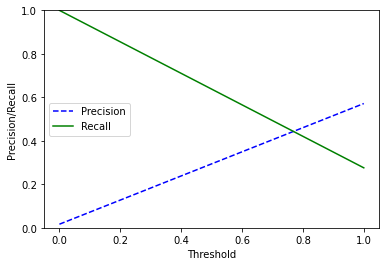

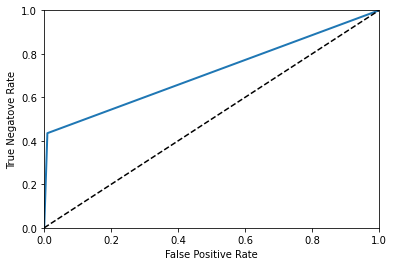

In [83]:
y_scores = cross_val_predict(clf, X_train_scaled, y_train.ravel(), cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)
plot_precision_recall(precisions, recalls, thresholds)
false_positive, true_negative, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(false_positive, true_negative)

### Checking Parameters with Grid Search

In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1], 
             "n_estimators" : [10, 30, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4]
             
             
             } 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=7)

grid.fit(X, y.ravel());

grid.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'max_features': 5, 'n_estimators': 50}

### Running the best GBM model

In [164]:
# Calculating the accuracy score
clf_best = GradientBoostingClassifier(n_estimators=50,
                                     learning_rate=0.05,
                                     max_features=5,
                                     max_depth=2,
                                     random_state=123
    )
clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(5)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [214]:
# Important: double check the best model with cross validation 
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(clf_best, X, y.ravel(), cv=10)
np.round(scores.mean(), 3)

0.988

In [166]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print("Accuracy Score is {0:.3f}".format(acc_score))

Accuracy Score is 0.988


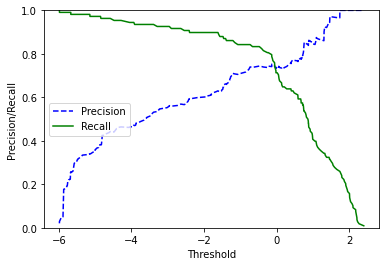

In [167]:
y_scores = cross_val_predict(clf_best, X_train_scaled, y_train.ravel(), cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

plot_precision_recall(precisions, recalls, thresholds)
plt.show()

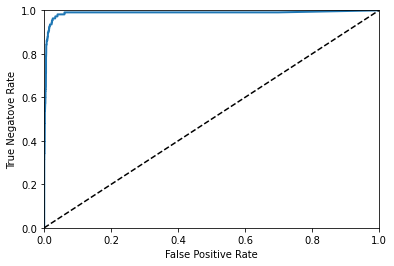

In [168]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

In [169]:
# Generate the confusion matrix
pd.DataFrame(confusion_matrix(y_test, predictions), index=["Pred 0", "Pred 1"], columns=["Actual 1", "Actual 0"])

,Actual 1,Actual 0
Pred 0,1712,13
Pred 1,8,21


In [170]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.663


In [171]:
# Generate classification report
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1725
           1       0.62      0.72      0.67        29

    accuracy                           0.99      1754
   macro avg       0.81      0.86      0.83      1754
weighted avg       0.99      0.99      0.99      1754



Extracting rules that were learned in training

In [219]:
n_classes, n_estimators = clf_best.estimators_.shape
for c in range(n_classes):
    for t in range(n_estimators):
        dtree = clf_best.estimators_[c, t]
        print("class={}, tree={}: {}".format(c, t, dtree.tree_))

        rules = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
        print(rules)

class=0, tree=0: <sklearn.tree._tree.Tree object at 0x7fa3c51bbce0>
   child_left  child_right  feature  threshold
0           1            4        7  -0.106241
1           2            3        1  -0.022965
2          -1           -1       -2  -2.000000
3          -1           -1       -2  -2.000000
4           5            6        0  -1.854326
5          -1           -1       -2  -2.000000
6          -1           -1       -2  -2.000000
class=1, tree=0: <sklearn.tree._tree.Tree object at 0x7fa3c51bba40>
   child_left  child_right  feature  threshold
0           1            4        0  -1.602776
1           2            3        4  -0.252550
2          -1           -1       -2  -2.000000
3          -1           -1       -2  -2.000000
4           5            6        0  -1.311529
5          -1           -1       -2  -2.000000
6          -1           -1       -2  -2.000000
class=2, tree=0: <sklearn.tree._tree.Tree object at 0x7fa3c51bb650>
   child_left  child_right  feature  thresho

### Out-of-sample Testing 

In [265]:
pd.set_option('use_inf_as_na', True)
oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4']
results_oos = pd.DataFrame()
for report in oos_reports:
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    # Generate out-of-sample classification report
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")
   
  

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.44
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6713
           1       0.20      1.00      0.33        19

    accuracy                           0.99      6732
   macro avg       0.60 